In [1]:
import Pkg; Pkg.activate("."); Pkg.instantiate(verbose=true)

  Activating project at `~/6.337/18.337-Project-SP2023/Stochastic Diffeqs`


In [2]:
Pkg.status()

      Status `~/6.337/18.337-Project-SP2023/Stochastic Diffeqs/Project.toml`
  [6e4b80f9] BenchmarkTools v1.3.2
  [b0b7db55] ComponentArrays v0.13.12
  [8f4d0f93] Conda v1.8.0
  [aae7a2af] DiffEqFlux v1.54.0
  [0c46a032] DifferentialEquations v7.7.0
  [31c24e10] Distributions v0.25.91
  [587475ba] Flux v0.13.16
  [f6369f11] ForwardDiff v0.10.35
  [bd48cda9] GraphRecipes v0.5.12
  [86223c79] Graphs v1.8.0
  [7073ff75] IJulia v1.24.0
  [4138dd39] JLD v0.13.3
  [b964fa9f] LaTeXStrings v1.3.0
  [b2108857] Lux v0.4.53
  [429524aa] Optim v1.7.5
  [7f7a1694] Optimization v3.14.1
  [253f991c] OptimizationFlux v0.1.4
  [91a5bcdd] Plots v1.38.11
  [438e738f] PyCall v1.95.1
  [d330b81b] PyPlot v2.11.1
  [731186ca] RecursiveArrayTools v2.38.3
  [1ed8b502] SciMLSensitivity v7.31.0
  [e88e6eb3] Zygote v0.6.61


In [3]:
using DiffEqFlux
using SciMLSensitivity
using Optimization
using DifferentialEquations.StochasticDiffEq
using DifferentialEquations.DiffEqCallbacks
using DifferentialEquations.DiffEqNoiseProcess
using Statistics, LinearAlgebra, Random
using Plots
using DifferentialEquations.DiffEqBase.EnsembleAnalysis
using BenchmarkTools
using LaTeXStrings
using Printf # print formatting
using ForwardDiff
using Graphs
using GraphRecipes
using RecursiveArrayTools
using Lux
using Lux.NNlib # to get access to additional activation functions

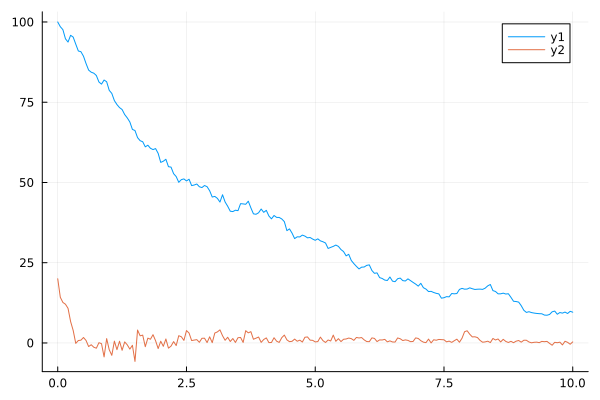

In [101]:
# set up problem: initial conditions, params, solver hyperparams
datasize = 201
tspan = (0.0, 10.0)
tsteps = range(tspan[1], tspan[2], length = datasize)
NOISE_STRUCT = zeros(Float64,2,4)
u_0 = Float64[
    100.0,
    20.0
]

# produce NN for rates expressions in drift and diffusion functions of SDE
function ratestodrift(u, p, t)
    R1,R2,R3,R4 = ratesmodel(u,rebuild(p),st)[1]
    return [
        R4-(R1+R3),
        R3-(R2+R4)
    ]
end

function ratestodiff(u, p, t)
    R1_r,R2_r,R3_r,R4_r = ratesmodel(u,rebuild(p),st)[1].^(1/2)
    return [
        -R1_r 0.0 -R3_r R4_r;
        0.0 -R2_r R3_r -R4_r
    ]
end

# generate feedforward NN, probably better to not use ReLU at final layer to enforce positive outputs, has zero gradients
# try softplus instead which still maps negative elements to upper half plane, need to import NNlib for it: 
# https://stackoverflow.com/questions/49982438/how-to-restrict-the-output-of-neural-network-to-be-positive-in-python-keras
# ratesmodel = Lux.Chain(Lux.Dense(2, 16, relu), Lux.Dense(16, 4, relu));
# per Prabhat suggestion, eliminate all ReLU! turn all to some other activation, e.g., softplus
# ratesmodel = Lux.Chain(Lux.Dense(2, 16, relu), Lux.Dense(16, 4, softplus));

ratesmodel = Lux.Chain(Lux.Dense(2, 16, softplus), Lux.Dense(16, 4, softplus));
p_nn, st = Lux.setup(Xoshiro(0), ratesmodel)

# can destructure params and Restructure them out of p_nn
flat, rebuild = Flux.destructure(p_nn)
rebuild(flat)

# reflecting condition, helps stabilize ensemble results
# see https://stackoverflow.com/questions/69049991/simulating-a-reflecting-boundary-sdeproblem
function affect!(integrator)
    if integrator.u[2] < 0
        integrator.u[2] = -integrator.u[2]
    end
end
condition(u,t,integrator) = true
cb_reflect = DiscreteCallback(condition,affect!;save_positions=(false,false))
cbs = CallbackSet(cb_reflect)

# need to implement functions to recover parameters from Lux structures
prob = SDEProblem(
    ratestodrift,
    ratestodiff,
    u_0,
    tspan,
    Flux.destructure(p_nn)[1],
    noise_rate_prototype = NOISE_STRUCT,
    callback=cbs
)

sol = solve(prob, EM(), dt=0.05, saveat=0.05; sensealg=TrackerAdjoint(), save_everystep=false)
plot(sol.t, Array(sol)')# , xlim = (0.0,10.0), ylim = (0,100))

# Solution: remove `save_everystep=false`

In [102]:
function loss_neuralsde(p,u=u_0)
    dt = 0.05
    prob = SDEProblem(ratestodrift, ratestodiff, u, tspan, p, noise_rate_prototype = NOISE_STRUCT, callback=cbs)
    sol = solve(prob, EM(), dt = dt, saveat = dt; sensealg=BacksolveAdjoint(autojacvec = SciMLSensitivity.ReverseDiffVJP(), noisemixing = true)) #BacksolveAdjoint(autojacvec = SciMLSensitivity.ReverseDiffVJP(), noisemixing = true))
    loss = sum(abs2,sol[:,:])
    return loss, sol
end

res_p = loss_neuralsde(flat,u_0)[2]
res = Zygote.gradient(p->loss_neuralsde(p,u_0)[1],flat)[1]
res2 = ForwardDiff.gradient(p -> loss_neuralsde(p, u_0)[1], flat)

116-element Vector{Float32}:
     -21.811516
   48121.25
   24030.98
 -540113.94
 -602910.6
  183356.58
     -13.76229
  683591.06
  -19153.459
      13.023447
 -731137.44
  100277.32
     244.42662
       ⋮
     -17.483515
      -0.156015
      -0.014174806
      19.437422
      -1.1032142f6
   42811.14
      11.765408
       1.3319275f6
  -31293.186
     654.0066
       3.936217
   36263.582

In [86]:
length(res_p.t)

201

# Get Ground Truth Moments

In [103]:
function trueSDEfunc!(du,u,p,t)
    @inbounds begin
        # α_1 = 0.1, α_2 = 0.2, α_3 = 0.2, α_4 = 0.5
        R1 = exp(p[1])*u[1]
        R2 = exp(p[2])*u[2]
        R3 = exp(p[3])*u[1]
        R4 = exp(p[4])*u[2]
        du[1] = R4-R1-R3
        du[2] = R3-R2-R4
    end
end

function true_noise_func!(du,u,p,t)
    @inbounds begin
        # α_1 = 0.1, α_2 = 0.2, α_3 = 0.2, α_4 = 0.5
        R1 = exp(p[1])*u[1]
        R2 = exp(p[2])*u[2]
        R3 = exp(p[3])*u[1]
        R4 = exp(p[4])*u[2]
        du[1, 1] = -sqrt(R1)
        du[1, 3] = -sqrt(R3)
        du[1, 4] = sqrt(R4)
        du[2, 2] = -sqrt(R2)
        du[2, 3] = sqrt(R3)
        du[2, 4] = -sqrt(R4)
    end
end

# new IC
u_0 = Float64[
    100.0,
    20.0
]
p_true = log.(Float64[
    0.1,
    0.2,
    0.2,
    0.5
])

# ground truth for two-pool model using ensemble of 100000 trajectories
# use callbacks from before, save_position = (false,false)
prob_truesde = SDEProblem(
    trueSDEfunc!,
    true_noise_func!,
    u_0,
    tspan,
    p_true,
    noise_rate_prototype = NOISE_STRUCT,
    callback=cbs
)

# do ensemble of N unique SDE solves (make sure seed != 1)
N = 100000
ensembleprob = EnsembleProblem(prob_truesde)
sol_true = solve(ensembleprob, EM(), dt=0.05, saveat = 0.05, trajectories = N)

# parse to remove failed simulations
parsed_sol_cb = [(sol_true.u[i].retcode != ReturnCode.Success ? nothing : sol_true.u[i]) for i in 1:length(sol_true.u)]
parsed_sol_cb = parsed_sol_cb[parsed_sol_cb.!=nothing]
truemean_cb = mean(parsed_sol_cb)[:,:]
truevar_cb = var(parsed_sol_cb)[:, :];

# number/proportion of failed simulations
println("$(N-length(parsed_sol_cb)) failed simulations, or $(1-length(parsed_sol_cb)/N)")

0 failed simulations, or 0.0


In [85]:
length(sol[1].t)

201

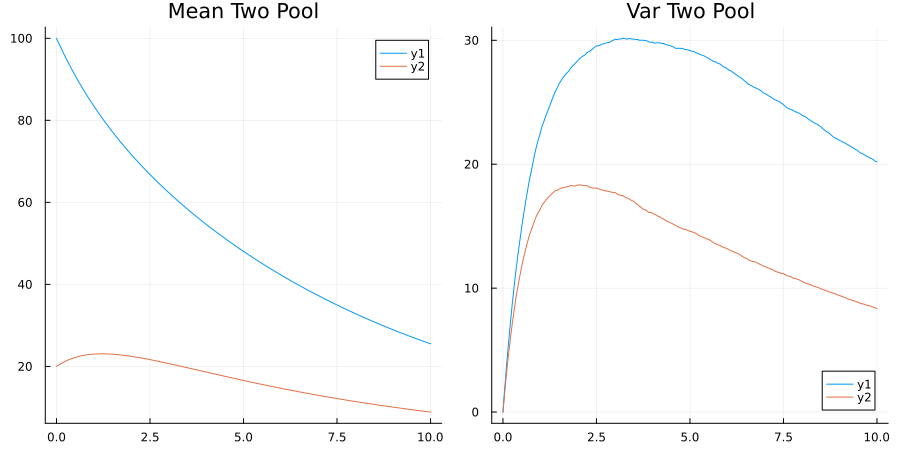

In [104]:
# plot ground truth
p_twopool_mean = plot(sol_true.u[1].t,truemean_cb',title = "Mean Two Pool")
p_twopool_var = plot(sol_true.u[1].t,truevar_cb', title = "Var Two Pool")

plot(
    p_twopool_mean,
    p_twopool_var,
    layout = (1,2),
    size = (900,450)
)

# Training on non-zero ICs

In [110]:
function loss_neuralsde2(p,u=u_0,n=100)
    dt = 0.05
    prob = SDEProblem(ratestodrift, ratestodiff, u, tspan, p, noise_rate_prototype = NOISE_STRUCT, callback=cbs)
    res = map(
        (x->solve(prob, EM(), dt = dt, saveat = dt; sensealg=InterpolatingAdjoint(autojacvec = SciMLSensitivity.ReverseDiffVJP(), noisemixing = true))),
        [u_0 for i in 1:n]
    )
    VA = VectorOfArray(res)
    arr = convert(Array,VA)
    means = mean(arr, dims = 3)
    vars = var(arr, dims = 3, mean = means)
    # elastic net, but also put the moments in the same magnitude, i.e., abs instead of abs2 for variances
    # this will also decrease the magnitude of your gradients to make training smoother!
    loss = sum(abs2, truemean_cb .- means) + (sum(abs, truevar_cb .- vars)) + 1.0 * sum(abs2, p) + 1.0 * sum(abs, p) # elastic net without hyperparameters optimized
    
    return loss
end

# manipulations of p_nn to get right structure and to train on the correct loss function
n=2
flat, rebuild = Flux.destructure(p_nn)
rebuild(flat)
test_loss = loss_neuralsde2(flat)
# res = Zygote.gradient(p->loss_neuralsde2(p,u_0,n),flat)[1] # was not working at all
res = ForwardDiff.gradient(p->loss_neuralsde2(p,u_0,n),flat)

116-element Vector{Float64}:
       9.794007400116735
  -33916.509981005795
  -19031.828160709676
  234006.65388726146
  268453.5681800165
  -84694.31289405064
       1.8971246733896878
 -318241.8251373883
   14812.935787158038
      -8.89699392127481
  337310.4189506971
  -49187.17129285749
   -1902.8059912837434
       ⋮
      95.36268378874695
      -2.802373112992896
      -3.3395352231153095
     -99.87246018485276
  466612.1092975415
   22571.803050995768
       9.317710924518453
 -389098.8099188221
   23514.610845974436
     610.2311445749167
      12.193589267575355
  -18831.548977129503

In [ ]:
# the ForwardDiff version of this optimization
# https://docs.sciml.ai/Optimization/stable/API/optimization_function/#Optimization.AutoForwardDiff
opt = ADAM(0.001)
losses = []
params_list = []
MAX_ITERS = 500 # around 60 seconds/iter on KKG comp, so ~5hrs for 500 iters

# save progress of solution, https://docs.sciml.ai/Optimization/stable/API/solve/#CommonSolve.solve-Tuple{OptimizationProblem,%20Any}
function callback(params,loss_val)
    # record round number and 
    println("Round $(length(params_list)) training loss: $(loss_val)")
    push!(losses,loss_val)
    push!(params_list,params)
    length(params_list) >= MAX_ITERS
end

# First round of training with n = 10
# need to add a slight positive value to the IC to excite non-zero dynamics
t1 = time_ns()
adtype = Optimization.AutoForwardDiff()
optf = Optimization.OptimizationFunction((x,p) -> loss_neuralsde2(x,u_0), adtype)
optprob = Optimization.OptimizationProblem(optf, flat)
result1 = Optimization.solve(optprob, opt, maxiters = MAX_ITERS, callback=callback);
t2 = time_ns()
println("Total time elapsed: $((t2-t1)/1.0e9) seconds")

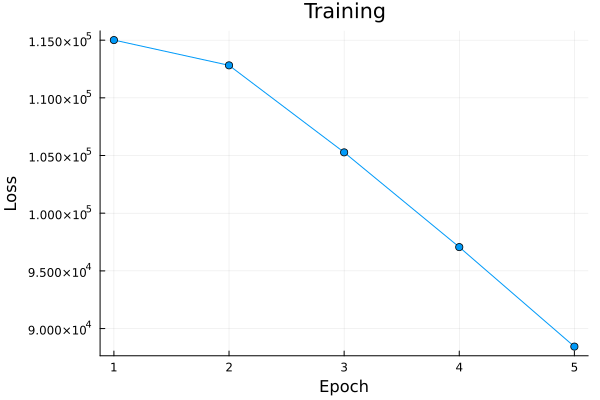

In [112]:
plot(1:MAX_ITERS,losses,ylabel = "Loss", xlabel = "Epoch", markershape=:circle, label="", title="Training")

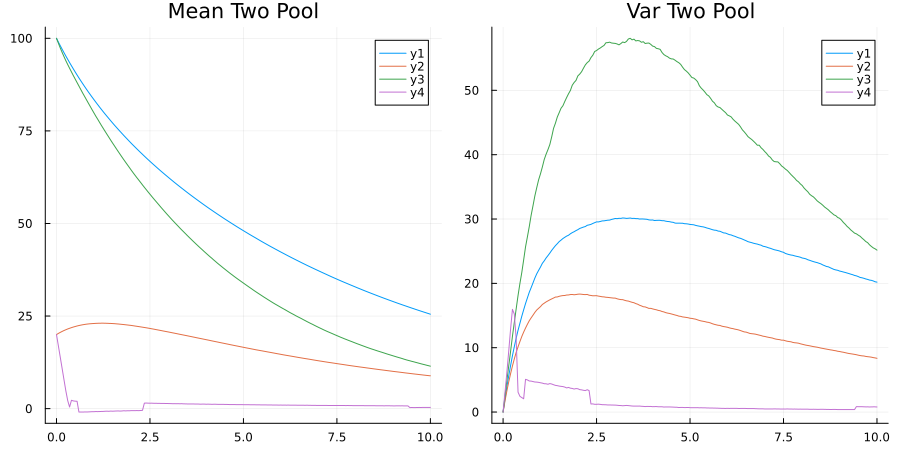

In [113]:
# need to implement functions to recover parameters from Lux structures
prob = SDEProblem(
    ratestodrift,
    ratestodiff,
    u_0,
    tspan,
    Flux.destructure(result1.u)[1],
    noise_rate_prototype = NOISE_STRUCT,
    callback=cbs
)
N = 10000
ensembleprob = EnsembleProblem(prob)
sol = solve(ensembleprob, EM(), dt=0.05, saveat=0.05; trajectories = N, sensealg=InterpolatingAdjoint(autojacvec = SciMLSensitivity.ReverseDiffVJP(), noisemixing = true))
trained_means = mean(sol, dims = 3)[:,:]
trained_vars = var(sol, dims = 3, mean = trained_means)[:,:]

# plot ground truth
p_twopool_mean = plot(sol_true.u[1].t,truemean_cb',title = "Mean Two Pool")
p_twopool_var = plot(sol_true.u[1].t,truevar_cb', title = "Var Two Pool")

# plot training results
plot!(p_twopool_mean, sol[1].t, trained_means')
plot!(p_twopool_var, sol[1].t, trained_vars')

plot(
    p_twopool_mean,
    p_twopool_var,
    layout = (1,2),
    size = (900,450)
)